![head.png](figures/head.jpg)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

In [1]:
# Packages used in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import optimize
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import coint

# Financial time series

Temporal financial data with observations that occur at some time $t$. Most financial data can be expressed as a time series.

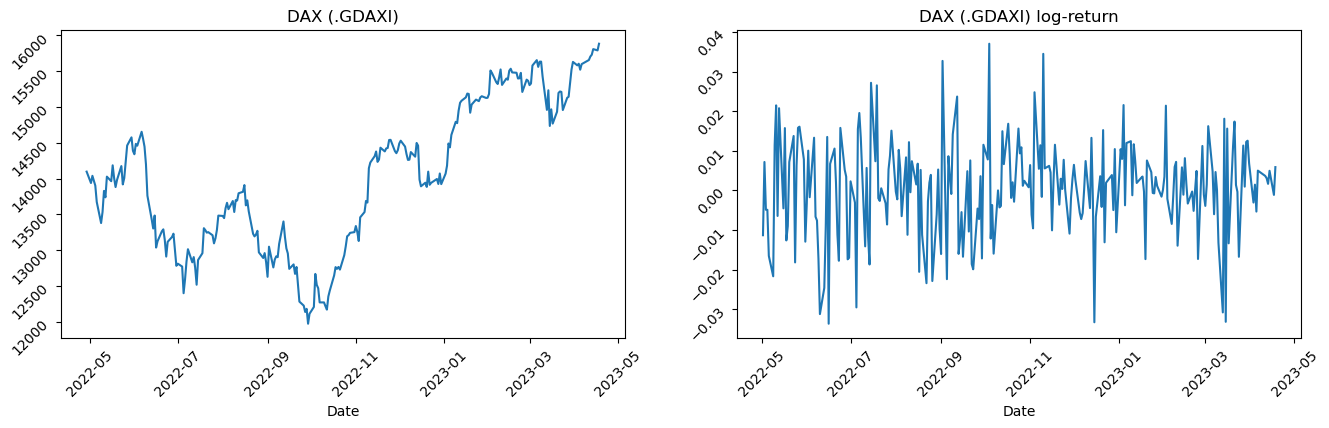

In [2]:
# Read data from CSV file
prices = pd.read_csv('homework/02_python_data.csv', index_col=0, parse_dates=True)
returns = prices.pct_change()
logreturns = np.log(prices) - np.log(prices.shift(1))

fig, axs = plt.subplots(1, 2, figsize=(16,4))
axs[0].plot(prices[".GDAXI"])
axs[0].set_xlabel('Date')
axs[0].title.set_text("DAX (.GDAXI)")
axs[0].tick_params(labelrotation=45)

axs[1].plot(logreturns[".GDAXI"])
axs[1].set_xlabel('Date')
axs[1].title.set_text("DAX (.GDAXI) log-return")
axs[1].tick_params(labelrotation=45)

## Correlation

Correlation is a statistical measure that quantifies the degree of association between two variables. In the context of finance, correlation is used to determine how closely the returns of two assets, indices, or other financial instruments move together over time.  Correlation may indicate any type of association, in statistics it usually refers to the degree to which a pair of variables are linearly related. Correlation is therefore often measured as the Pearson correlation coefficient, a measure for linear association between two random variables $X$ and $Y$

$$\rho_{X,Y} = \text{corr}(X,Y) = \frac{\text{cov}(X,Y)}{\sigma_X \sigma_Y} = \frac{\mathrm{E}[(X - \mu_X)(Y - \mu_Y)]}{\sigma_X \sigma_Y}, \text{  if  } \sigma_X \sigma_Y > 0$$

A high positive correlation indicates that the assets tend to move in the same direction, while a high negative correlation implies that they move in opposite directions. A correlation close to zero suggests no significant relationship between the two assets. 

Linear association, as measured by Pearson's correlation coefficient does not adequately capture non-linear associations. As an example, consider the random variable $X$ as well as $Y = X^2$.

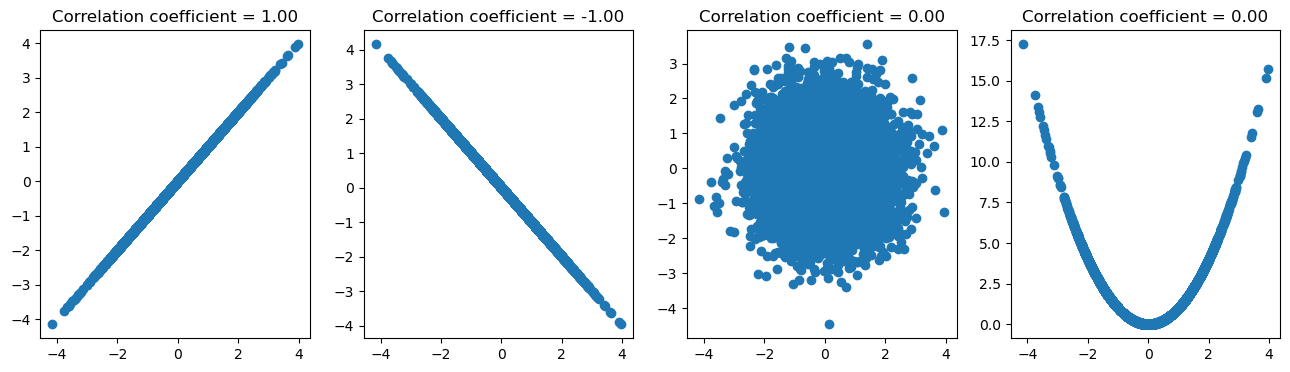

In [3]:
np.random.seed(88888)
X = np.random.normal(size=10000)
Y = np.random.normal(size=10000)

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
# Positive
axs[0].scatter(X,X)
axs[0].title.set_text(f"Correlation coefficient = {np.corrcoef(X,X)[0,1]:.2f}")
# Negative
axs[1].scatter(X,-X)
axs[1].title.set_text(f"Correlation coefficient = {np.corrcoef(X,-X)[0,1]:.2f}")
# Independent
axs[2].scatter(X,Y)
axs[2].title.set_text(f"Correlation coefficient = {np.corrcoef(X,Y)[0,1]:.2f}")
# Non-linear
axs[3].scatter(X,X**2)
axs[3].title.set_text(f"Correlation coefficient = {np.corrcoef(X,X**2)[0,1]:.2f}")
plt.show()

## Linear regression

Consider a simple univariate [linear regression model](https://en.wikipedia.org/wiki/Linear_regression) of the form

$$y_i = \beta_0 + \beta_1 x_i + \epsilon_i$$

We often call $\beta_0$ the intercept and $\beta_1$ the slope or steepness.

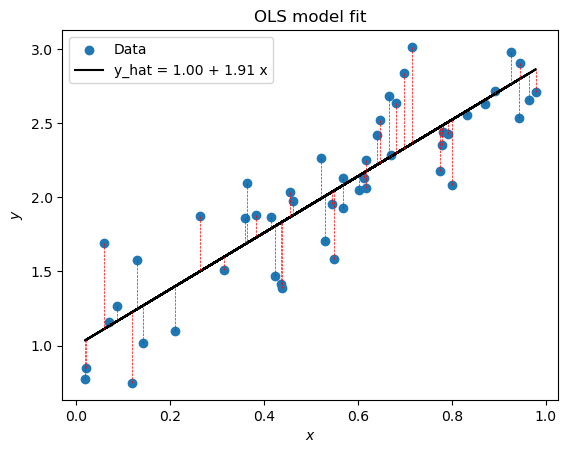

In [4]:
# Generate sample data
np.random.seed(0)
x = np.random.rand(50)
y = 2 * x + 1 + 0.3 * np.random.normal(0, 1, len(x))

# Fit a linear model
def fun(beta):
    y_hat = beta[0] + beta[1] * x
    squares = (y - y_hat)**2
    return sum(squares)
# Ordinary least squares (OLS)
result = optimize.minimize(fun, x0=[0,0], method='BFGS')
intercept, slope = result.x

#slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
y_hat = slope * x + intercept
# Calculate residuals
residuals = y - y_hat

# Plot the scatter plot with linear model fit
plt.scatter(x, y, label='Data')
plt.plot(x, y_hat, color='black', label=f'y_hat = {intercept:.2f} + {slope:.2f} x')
# Indicate the residuals
for i in range(len(x)):
    plt.plot([x[i], x[i]], [y[i], y_hat[i]], color='red', linestyle='--', linewidth=0.5)
plt.ylabel('$y$')
plt.xlabel('$x$')
plt.legend()
plt.title('OLS model fit')
plt.show()

### Coefficient of determination (R-squared)

R-squared $R^2$ is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. It provides a measure of how well the observed data can be explained by the model.

$$
R^2 = \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2} = \frac{\sum_i \epsilon_i^2}{\sum_i (y_i - \bar{y})^2} = \frac{ \text{Residual sum of squares} }{ \text{Total sum of squares} },
$$

where $y_i$ is the observed and $\hat{y}_i$ is the predicted value. You can think of it this way: we compute the ratio between the errors from prediction $\hat{y}_i$ versus the errors from naively predicting $y_i$ with its average $\bar{y}_i$. The fraction of variance that can be explained by the model is therefore $R^2$, and the fraction that cannot be explained is $1 - R^2$.

In a linear regression with intercept, $R^2$ is the square of the Person correlation coefficient between observed and predicted values of the dependent variable, i.e.

$$
R^2 = \rho_{X,Y}^2
$$


In [5]:
# R-squared
residual_sum_squares = sum((y - y_hat)**2)
total_sum_squares = sum((y - y.mean())**2)
print(f"R-squared   = {1 - residual_sum_squares / total_sum_squares:.4f}")
# Correlation squared
print(f"Corr(X,Y)^2 = {np.corrcoef(x,y)[0,1]**2:.4f}")

R-squared   = 0.7780
Corr(X,Y)^2 = 0.7780


### Multivariate linear regression (`scipy.stats`)

Multivariate linear regression is a statistical technique that allows us to predict the value of one dependent variable (also known as the outcome variable) based on the values of two or more independent variables (also known as predictor variables). It is an extension of simple linear regression that involves more than one explanatory variable, hence,

$$y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + ... + \beta_p x_{ip} + \epsilon_i$$

which can be expressed in matrix notation as

$$
\mathbf{y} = \mathbf{X} \mathbf{\beta} + \mathbf{\epsilon}
$$



In [6]:
# Generate example data
np.random.seed(0)
x1 = np.random.rand(50)
x2 = np.random.rand(50)
x3 = np.random.rand(50)
# Create a dependent variable + error
y = 2*x1 + 5*x2 + 1 + 0.3 * np.random.normal(0, 1, len(x))
# Note that y is not a function of x3

# Combine the vectors of explanatory variables
X = np.column_stack([x1, x2, x3])
# Add the intercept, i.e. prepend a vector of ones
X = sm.add_constant(X)
# Fit the model
fitted_model = sm.OLS(y, X).fit()
# Show results
print(fitted_model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     440.3
Date:                Tue, 23 Apr 2024   Prob (F-statistic):           7.14e-34
Time:                        21:58:15   Log-Likelihood:                -8.2512
No. Observations:                  50   AIC:                             24.50
Df Residuals:                      46   BIC:                             32.15
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9363      0.157      5.958      0.0

## Autoregressive (AR) model

An [autoregressive (AR) model](https://en.wikipedia.org/wiki/Autoregressive_model), employed in fields such as statistics, econometrics, and signal processing, characterizes a specific kind of random process. It posits that the output variable is linearly dependent on its preceding values [(also see autocorrelation)](https://en.wikipedia.org/wiki/Autocorrelation) and an unpredictable, stochastic component, making the model a form of stochastic difference equation (also known as recurrence relation). When combined with the moving-average (MA) model, the AR model forms a crucial part of the autoregressive–moving-average (ARMA) and autoregressive integrated moving average (ARIMA) models of time series, which possess a more complex stochastic structure. It also serves as a special instance of the vector autoregressive model (VAR), a system consisting of multiple interrelated stochastic difference equations with several evolving random variables. The basic structure of an AR model is as follows

$$x_t = c + \phi_1 x_{t-1} + \phi_2 x_{t-2} + ... + \phi_p x_{t-p} + \epsilon_t$$

where $x_t$ is the time series value at time $t$, $c$ is a constant, $\phi$ are the parameters of the model $x_{t-1}, x_{t-2}, ..., x_{t-p}$ are lagged values of the time series and $\epsilon_t$ is the unpredictable error term at time $t$. The order of the AR model is $p$ (i.e., the number of lagged observations in the model).

Note that in practice, it's important to ensure the time series is [stationary](https://en.wikipedia.org/wiki/Stationary_process) before fitting an AR model, as the model assumes that the time series does not have any trend or seasonal components. In addition, model selection (i.e., choosing the appropriate number of lags) is a critical part of using AR models effectively.

Estimated Parameters AR(1): [0.00811267 0.4804013 ]
Estimated Parameters AR(10): [ 0.01552134  0.76962717 -0.54284216  0.45085355 -0.41270782  0.32654098
 -0.32654285  0.21285502 -0.1447886   0.135695   -0.00186549]


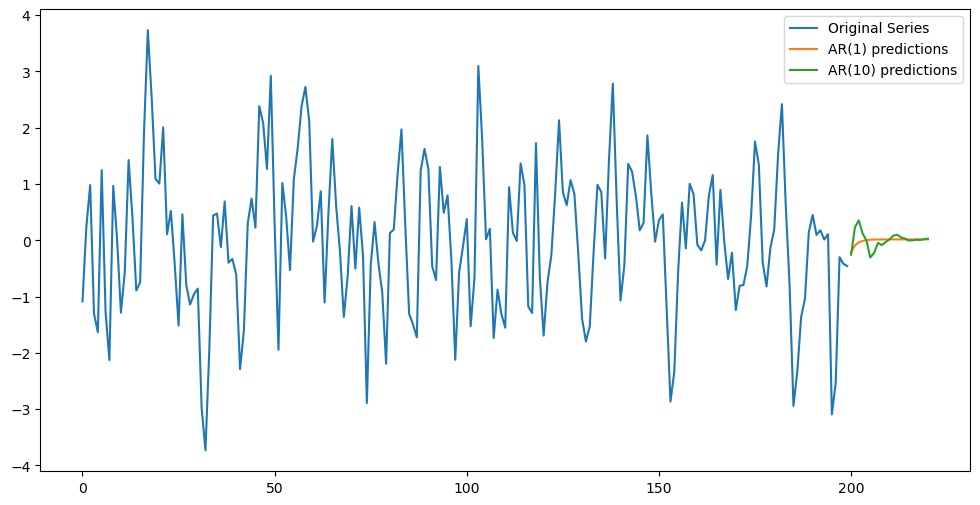

In [7]:
# Set the seed for reproducibility
np.random.seed(123)

# Generate a time series of 200 points
n = 200
error = np.random.normal(0, 1, n)
lagged_error = np.roll(error, 1)
lagged_error[0] = 0
time_series = 0.7*lagged_error + error

# Fit an AR(1) model to the time series
ar1_fit = AutoReg(time_series, lags=1).fit()
# Fit an AR(10) model to the time series
ar10_fit = AutoReg(time_series, lags=10).fit()

# Print out the parameter estimates
print(f'Estimated Parameters AR(1): {ar1_fit.params}')
print(f'Estimated Parameters AR(10): {ar10_fit.params}')

# Make predictions
n_predictions = 20
ar1_predictions = ar1_fit.predict(start=len(time_series), end=len(time_series)+n_predictions)
ar10_predictions = ar10_fit.predict(start=len(time_series), end=len(time_series)+n_predictions)

# Plot the time series and the predictions
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Original Series')
plt.plot(range(n, n+n_predictions+1), ar1_predictions, label='AR(1) predictions')
plt.plot(range(n, n+n_predictions+1), ar10_predictions, label='AR(10) predictions')
plt.legend()
plt.show()

## Moving-average (MA) model

[Moving-average (MA)](https://en.wikipedia.org/wiki/Moving-average_model) models are another class of models used in time series forecasting, which operate somewhat differently from Auto Regressive (AR) models.

A Moving Average model uses the dependency between an observation and a residual error from a mean model applied to lagged observations. Unlike an AR model that uses past observations, an MA model uses past forecast errors in a regression-like model.

The basic structure of an MA model is as follows

$$x_t = \mu + \epsilon_t + \Phi_1 \epsilon_{t-1} + \Phi_1 \epsilon_{t-2} + ... + \Phi_q \epsilon_{t-q}$$

where $\mu$ is the mean of the time series $\epsilon_t$ is the white noise at time $t$, $\Phi$ are the parameters of the model, $\epsilon_{t-1}, \epsilon_{t-2}, ..., \epsilon_{t-q}$ are the white noise at previous points in time and $q$ is the order of the MA model (i.e., the number of lagged forecast errors in the prediction equation).

One can combine both AR and MA into the [Autoregressive–moving-average (ARMA)](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model) model or its generalization, the [autoregressive integrated moving average (ARIMA)](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) model. The I (for "integrated") indicates that the data values have been replaced with the difference between their values and the previous values (and this differencing process may have been performed more than once). Recall that these models require a stationary time series, a property that can often be achieved by integrating.

Estimated Parameters AR(1): [ 0.00879063  0.74323254  0.00893375  0.08681321 -0.00122873 -0.03601575
 -0.09068916 -0.08049426 -0.05224911 -0.04533681  0.06487233  1.0635038 ]


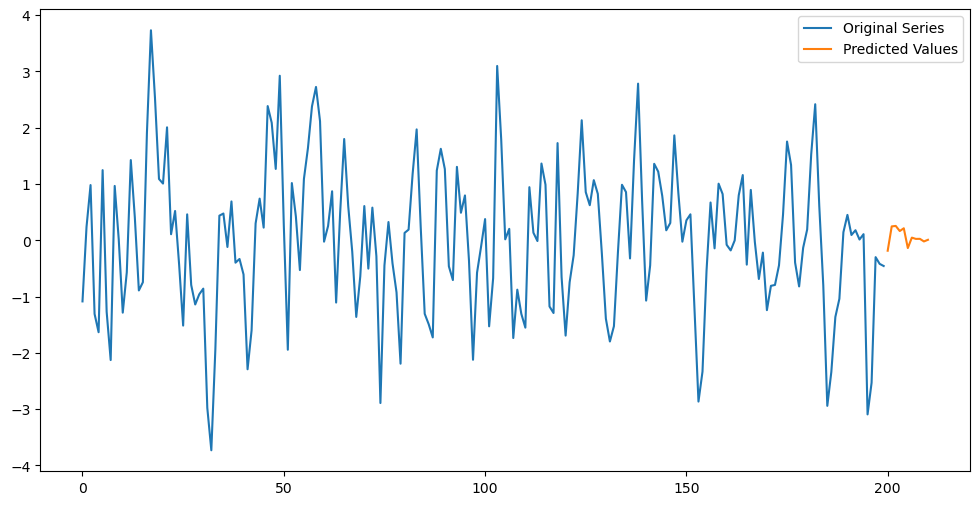

In [8]:
# Set the seed for reproducibility
np.random.seed(123)

# Generate a time series of 200 points
n = 200
error = np.random.normal(0, 1, n)
time_series = error + 0.7*np.roll(error, 1)
time_series[0] = error[0]

# Fit an MA model to the time series
arima0010_fit = ARIMA(time_series, order=(0, 0, 10)).fit()

# Print out the parameter estimates
print(f'Estimated Parameters AR(1): {arima0010_fit.params}')

# Make predictions
arima0010_predictions = arima0010_fit.predict(start=len(time_series), end=len(time_series)+10)

# Plot the time series and the predictions
plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Original Series')
plt.plot(range(n, n+11), arima0010_predictions, label='Predicted Values')
plt.legend()
plt.show()

## Cointegration

[Cointegration](https://en.wikipedia.org/wiki/Cointegration) is a statistical concept used frequently in econometrics and finance. It's a vital concept used to test the correlation between two or more time series. Simply, if two or more series are individually non-stationary, but a linear combination of them is stationary, we can say the series are cointegrated. Cointegration is different from correlation. Correlation measures the degree to which two securities move in relation to each other. On the other hand, cointegration determines whether the distance between them remains constant over time.

Let's explore the concept by creating two synthetic time-series that are cointegrated. A common way to generate two cointegrated series is to start with a random walk and create a second series that is some fixed linear combination of the first, plus some noise. You can see that the two series share a common data generating process (random walk) but deviate from the process by their individual noise.

In [9]:
# Seed the random number generator
np.random.seed(0)

# Generate an instance of white noise
white_noise = np.random.normal(size=1000)

# Create a random walk around which to 'center' series
random_walk = np.cumsum(white_noise)

# Create series1 and series2
noise1 = np.random.normal(size=1000)
noise2 = np.random.normal(size=1000)

series1 = random_walk + noise1
series2 = random_walk + noise2

Cointegration between two or more time series can be tested using several methods. One common method is the Engle-Granger two-step method. Another frequently used method is the Johansen test. Here's a brief overview of each method:

**Engle-Granger Two-Step Method**

The Engle-Granger method involves two steps:

First, check if each time series is non-stationary (i.e., has a unit root). This is often done using an Augmented Dickey-Fuller (ADF) test or a Phillips-Perron test. If the series are not stationary, they may be differenced until they are, or until it is clear that differencing won't help. 

Next, if all series are I(1) (integrated of order 1), regress one series on the others to obtain the estimated residuals. This is the first step of the Engle-Granger method. The residuals from this regression are then checked for stationarity, again using an ADF or Phillips-Perron test. If the residuals are stationary, the series are said to be cointegrated.

In Python, you can use the `statsmodels.tsa.stattools.coint` function to perform the Engle-Granger test.

**Johansen Test**

The Johansen test is a method for testing cointegration among multiple, more than two, time series. It's based on the rank of a matrix of long-run coefficients where the rank of the matrix indicates the number of cointegrating vectors.

You can use the `statsmodels.tsa.vector_ar.vecm` module in Python to perform the Johansen test.

If p-value = 0.0 < 1% (confidence level) reject H0, hence, the series are cointegrated.


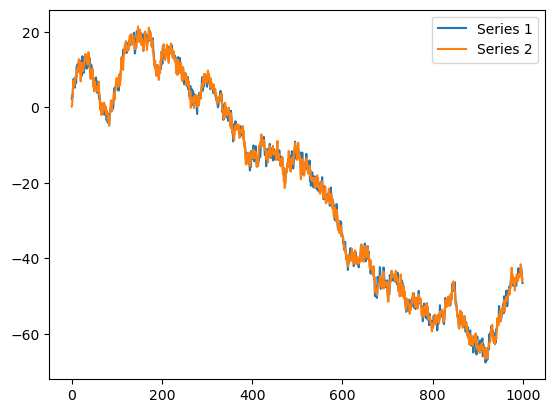

In [10]:
# Test for cointegration
score, pvalue, _ = coint(series1, series2)
print(f'If p-value = {pvalue} < 1% (confidence level) reject H0, hence, the series are cointegrated.')

# Plot the two time series
plt.plot(series1, label='Series 1')
plt.plot(series2, label='Series 2')
plt.legend(loc='best')
plt.show()

[Pairs trading](https://en.wikipedia.org/wiki/Pairs_trade) is an example for the use of cointegration in practice, where the spread between two cointegrated assets is tracked. If the spread deviates significantly from its mean, one asset is shorted and the other is bought, with the expectation that the spread will return to its mean, thereby resulting in a profit. A deviation from the mean is also often seen as an error or deviation from the equilibrium level.

The Error Correction Model (ECM) is a concept in econometrics that's closely related to cointegration. The purpose of ECM is to indicate the speed at which a dependent variable returns to equilibrium after a change in an independent variable. In other words, it helps us understand how the system corrects itself.

Given two cointegrated series, the Error Correction Model expresses changes in one series as a function of the level of disequilibrium in the cointegrating relationship (the 'error'), as well as changes in the other series.

First, let's compute the residual (error term) of the cointegrated series. This residual will show us how far off our cointegrating relationship is from equilibrium

In [11]:
# Fit a simple linear regression to the two series
model = sm.OLS(series1, series2)
results = model.fit()

# Get the residuals
residuals = results.resid

Now, let's create the ECM by regressing the changes in series2 on changes in series1 and the lagged residuals.

In [12]:
# Compute changes in series1 and series2
delta_series1 = np.diff(series1)
delta_series2 = np.diff(series2)

# Lag the residuals by one period
lagged_residuals = residuals[1:-1]

# Trim the changes to be the same length as lagged_residuals
delta_series1 = delta_series1[:-1]
delta_series2 = delta_series2[:-1]

# Put everything into a dataframe
df = pd.DataFrame({
    'Delta_Series1': delta_series1,
    'Delta_Series2': delta_series2,
    'Lagged_Residuals': lagged_residuals
})

# Fit the Error Correction Model
ecm_model = sm.OLS(df['Delta_Series2'], sm.add_constant(df[['Delta_Series1', 'Lagged_Residuals']]))
ecm_results = ecm_model.fit()

print(ecm_results.summary())

                            OLS Regression Results                            
Dep. Variable:          Delta_Series2   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     397.7
Date:                Tue, 23 Apr 2024   Prob (F-statistic):          1.20e-127
Time:                        21:58:16   Log-Likelihood:                -1588.9
No. Observations:                 998   AIC:                             3184.
Df Residuals:                     995   BIC:                             3198.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0031      0.038  

In the results summary, the coefficient of `Lagged_Residuals` tells us the speed of adjustment back to the long-run equilibrium after a change in `Series1`. For instance, a coefficient of -0.5 would suggest that half of the disequilibrium from the previous period is corrected within the next period.

The coefficient of the lagged residuals in an error correction model (ECM) should be negative if the system is mean-reverting, i.e., it tends to return to a long-term equilibrium state. This is because if the system is above the equilibrium level, the negative coefficient would predict a downward adjustment, and vice versa.

In the context of an [Error Correction Model (ECM)](https://en.wikipedia.org/wiki/Error_correction_model), the lead-lag relationship refers to the dynamic interplay between the variables in the system, where changes in one variable (the "lead") are followed by changes in another variable (the "lag"). In our ECM example, we used two variables: ``Delta_Series1`` (the lead) and ``Lagged_Residuals`` (the lag). The lead variable, ``Delta_Series1``, represents the current changes in the second series, while the lag variable, ``Lagged_Residuals``, represents the disequilibrium or the error term from the previous period.

The coefficient of Delta_Series1 indicates how changes in series1 are expected to be followed by changes in series2. If this coefficient is positive, it means that an increase in ``series1`` is typically followed by an increase in ``series2``, and vice versa. The coefficient of Lagged_Residuals is the speed of adjustment term. It represents how quickly ``series2`` reverts to the equilibrium after a shock. If this coefficient is negative (as it should be in a mean-reverting system), it means that if the system is above its equilibrium level (i.e., ``series2`` is higher than ``series1`` more than it should be), it tends to decrease, and vice versa.

In summary, in an ECM, the lead-lag relationship describes the dynamic interaction between the variables in the system and the speed at which the system reverts to equilibrium after a shock. This relationship is crucial for understanding the behavior of the system and for forecasting future values.

## Empirical properties of financial time series

Before attempting to model or forecast financial time series, one has to thoroughly understand the properties of the underlying process. Luckily,
[empirical properties of asset returns: stylized facts and statistical issues](http://rama.cont.perso.math.cnrs.fr/pdf/empirical.pdf) have been well researched. Some of the commonly observed empirical stylized facts about financial time series are:

* [**Heavy tails**](https://en.wikipedia.org/wiki/Heavy-tailed_distribution): Financial returns are not normally distributed and often exhibit "heavy tails" - extreme positive or negative returns are more likely than what would be expected under a normal distribution. The heavy tails in financial returns can be modeled using "fat-tailed" distributions. A common choice is the [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution), which has heavier tails than the normal distribution. Another approach is to use the [Generalized Hyperbolic](https://en.wikipedia.org/wiki/Generalised_hyperbolic_distribution) distribution or its special cases the [Normal Inverse Gaussian (NIG)](https://en.wikipedia.org/wiki/Normal-inverse_Gaussian_distribution) distribution. 

* [**Volatility clustering (heteroskedasticity)**](https://en.wikipedia.org/wiki/Homoscedasticity_and_heteroscedasticity): High-volatility periods are often followed by high-volatility periods, and low-volatility periods are often followed by low-volatility periods. This is usually modeled with [Autoregressive Conditional Heteroskedasticity (ARCH)](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity) models and their extensions such as [Generalized ARCH (GARCH)](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity) models. These models allow the variance of the returns to change over time in a way that captures the volatility clustering phenomenon.

* **Leverage effect**: Volatility often increases when prices go down, and decreases when prices go up. This can be modeled by adding an asymmetric term to the GARCH model, which makes the volatility depend not only on the magnitude of past returns but also on the sign of those returns. This leads to models like the [GJR-GARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity) model or the [EGARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity) model, which can capture the so-called "leverage effect".

Financial time series modelling choices often require implicit assumptions an the efficiency of financial markets, see [efficient-market hypothesis](https://en.wikipedia.org/wiki/Efficient-market_hypothesis).

## Limits

Investment management firms that employ mathematical and statistical methods in the design and execution of their investment programs have produced exceptional returns in the past and still continue to do so. However, they have also created exceptional losses, see e.g. the case of [Long-Term Capital Management](https://en.wikipedia.org/wiki/Long-Term_Capital_Management).

![LTCM.png](https://upload.wikimedia.org/wikipedia/commons/e/ec/LTCM.png)